# GradCAM & LayerCAM

#### load model

In [182]:
import torch
model = torch.load('torch_alex.pth')
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### load image & Image normalization

In [183]:
from utils import *
import numpy as np
import torch.nn.functional as F
import PIL.Image as Image
import os

def get_jpg_files(path):
    pil_imgs= []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                img_path=os.path.join(root, file)
                pil_imgs.append( Image.open(img_path))

    return pil_imgs

data4_path = 'data4'
pil_imgs = get_jpg_files(data4_path)
normed_imgs=[]

for pil_img in pil_imgs:
    normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255)
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    normed_imgs.append((normalizer(torch_img),torch_img))

d:\LenovoSoftstore\Install\anaconda\envs\myenv\lib\site-packages\torch\nn\functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


#### Register Hook

In [184]:
import torch.nn as nn
layer_gradients=[]

def get_output_gradients(module, grad_input, grad_output):
    layer_gradients.append(grad_input[0])

model.features.register_backward_hook(get_output_gradients)

#### Get Feature Map 

In [185]:
sample_img=normed_imgs[1][0]
origin_img=normed_imgs[1][1]
forward=[]
forward.append(sample_img)
for module in model.features:
    forward.append(module(forward[-1]))
output=model(sample_img)

d:\LenovoSoftstore\Install\anaconda\envs\myenv\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [186]:
cat_score=output[0][0]
dog_score=output[0][1]

In [187]:
model.zero_grad()
cat_score.backward()
layer_gradients[0].shape 

torch.Size([1, 256, 13, 13])

In [188]:
forward[-3].shape

torch.Size([1, 256, 13, 13])

## LayerCAM

In [192]:
import torch
import torchvision.utils as vutils
from PIL import Image

def visualize_cam(mask, img, output_path):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        output_path (str): output path to save the result image
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    
    heatmap = cv2.applyColorMap(np.uint8(655 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap + img
    result = result.div(result.max()).squeeze()

    # 将result保存为图像文件
    vutils.save_image(result, output_path)

    # 打开保存的图像文件
    saved_image = Image.open(output_path)
    
    return heatmap, saved_image

In [190]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

feature_map=forward[-3]
weight=layer_gradients[0]
weight=F.relu(weight)
# 将每个6x6的页与权重矩阵相乘
mult = torch.mul(feature_map,weight)
# mult = F.normalize(mult, dim=0)
# mult=torch.sub(mult,torch.min(mult))
# 对乘积页进行元素相加，得到单通道矩阵
summed = torch.sum(mult, dim=1, keepdim=True)

# 经过ReLU激活函数
activated = F.relu(summed)

# 上采样到指定的大小
n = normed_imgs[0][0].shape[2:]
upsampled = F.upsample(activated, size=n, mode='bilinear', align_corners=False)
# saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)


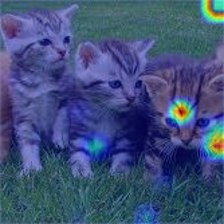

In [193]:
heatmap, saved_image = visualize_cam(upsampled.detach().numpy(),origin_img.detach().numpy(), output_path='layercam_cat_cat.png')
saved_image